In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:17
🔁 Restarting kernel...


In [ ]:
!mamba install -c conda-forge rdkit


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.1.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['rdkit']

[+] 0.0s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.1s
conda-forge/linux-64

In [ ]:
import rdkit
from rdkit import Chem

import numpy as np 
import os
from rdkit.Chem import rdmolops
from scipy import sparse
import pandas as pd

from tqdm import tqdm
from rdkit.Chem.AllChem import EmbedMolecule
from rdkit.Chem import MolFromSmiles

from rdkit.Chem import AllChem as Chem
from rdkit.Chem import rdMolTransforms

In [ ]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

from torch_geometric.data import Data
import torch.nn as nn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 48.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 19.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 33.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-_kc0

Edge_P

In [ ]:
from torch_geometric.data import Batch, Data
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.utils import to_dense_adj, dense_to_sparse, subgraph

In [ ]:
class EdgePerturbation():
    
    """
    Edge perturbation on the given graph or batched graphs. Class objects callable via 
    method :meth:`views_fn`.
    
    Args:
        add (bool, optional): Set :obj:`True` if randomly add edges in a given graph.
            (default: :obj:`True`)
        drop (bool, optional): Set :obj:`True` if randomly drop edges in a given graph.
            (default: :obj:`False`)
        ratio (float, optional): Percentage of edges to add or drop. (default: :obj:`0.1`)
    """

    def __init__(self, add=True, drop=False, ratio=0.1):
        self.add = add
        self.drop = drop
        self.ratio = ratio
        
    def __call__(self, data):
        return self.views_fn(data)
        
    def do_trans(self, data):
        node_num, _ = data.x.size()
        _, edge_num = data.edge_index.size()
        perturb_num = int(edge_num * self.ratio)

        edge_index = data.edge_index.detach().clone()
        idx_remain = edge_index
        idx_add = torch.tensor([]).reshape(2, -1).long()

        if self.drop:
            idx_remain = edge_index[:, np.random.choice(edge_num, edge_num-perturb_num, replace=False)]

        if self.add:
            idx_add = torch.randint(node_num, (2, perturb_num))

        new_edge_index = torch.cat((idx_remain, idx_add), dim=1)
        new_edge_index = torch.unique(new_edge_index, dim=1)

        return Data(x=data.x, edge_index=new_edge_index)

    def views_fn(self, data):
        """
        Method to be called when :class:`EdgePerturbation` object is called.
        
        Args:
            data (:class:`torch_geometric.data.Data`): The input graph or batched graphs.
            
        :rtype: :class:`torch_geometric.data.Data`.  
        """

        if isinstance(data, Batch):
            dlist = [self.do_trans(d) for d in data.to_data_list()]
            return Batch.from_data_list(dlist)
        elif isinstance(data, Data):
            return self.do_trans(data)

In [ ]:
class UniformSample():
    """
    Uniformly node dropping on the given graph or batched graphs. 
    Class objects callable via method :meth:`views_fn`.
    
    Args:
        ratio (float, optinal): Ratio of nodes to be dropped. (default: :obj:`0.1`)
    """

    def __init__(self, ratio=0.1):
        self.ratio = ratio
    
    def __call__(self, data):
        return self.views_fn(data)
    
    def do_trans(self, data):
        
        node_num, _ = data.x.size()
        _, edge_num = data.edge_index.size()
        
        keep_num = int(node_num * (1-self.ratio))
        idx_nondrop = torch.randperm(node_num)[:keep_num]
        mask_nondrop = torch.zeros_like(data.x[:,0]).scatter_(0, idx_nondrop, 1.0).bool()
        
        edge_index, _ = subgraph(mask_nondrop, data.edge_index, relabel_nodes=True, num_nodes=node_num)
        return Data(x=data.x[mask_nondrop], edge_index=edge_index)
    
    def views_fn(self, data):
        """
        Method to be called when :class:`UniformSample` object is called.
        
        Args:
            data (:class:`torch_geometric.data.Data`): The input graph or batched graphs.
            
        :rtype: :class:`torch_geometric.data.Data`.  
        """

        if isinstance(data, Batch):
            dlist = [self.do_trans(d) for d in data.to_data_list()]
            return Batch.from_data_list(dlist)
        elif isinstance(data, Data):
            return self.do_trans(data)

Dataset

In [ ]:
import os
import torch
import random
import torch.nn.functional as F
from torch_geometric.utils import degree
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.data import Data, Batch, Dataset

In [ ]:
DATA_SPLIT = [0.7, 0.2, 0.1] # Train / val / test split ratio

In [ ]:
def get_max_deg(dataset):
	"""
	Find the max degree across all nodes in all graphs.
	"""
	max_deg = 0
	#row, col = dataset[0].edge_index

	for data in dataset:
		edge_index = data.edge_index.view(2,-1)
		print(edge_index.shape)
		row, col = edge_index #data.edge_index.view(2,-1)
		num_nodes = data.num_nodes
		if num_nodes == 0:
			num_nodes = edge_index.shape[1]
		deg = degree(row, num_nodes)
		deg = max(deg).item()
		if deg > max_deg:
			max_deg = int(deg)
	return max_deg

class CatDegOnehot(object):
	"""
	Adds the node degree as one hot encodings to the node features.
	Args:
		max_degree (int): Maximum degree.
		in_degree (bool, optional): If set to :obj:`True`, will compute the in-
			degree of nodes instead of the out-degree. (default: :obj:`False`)
		cat (bool, optional): Concat node degrees to node features instead
			of replacing them. (default: :obj:`True`)
	"""

	def __init__(self, max_degree, in_degree=False, cat=True):
		self.max_degree = max_degree
		self.in_degree = in_degree
		self.cat = cat

	def __call__(self, data):
		
		try:
				#print('xx',data.x)
				#print(data.edge_index.shape[0])
				if data.edge_index.shape[0]==0:
					print('yolo')
					data.edge_index = torch.tensor([[0, 1],[0, 2]])
				#print(data.edge_index)
				idx, x = data.edge_index[1 if self.in_degree else 0], data.x
				#print('xxy',idx)
				#print(x)
				if isinstance(x, torch.Tensor):
					x = torch.tensor(x)			

				#print('dnum',data.num_nodes)

				deg = degree(idx, data.num_nodes, dtype=torch.long)
				deg = F.one_hot(deg, num_classes=self.max_degree + 1).to(torch.float)

				if x is not None and self.cat:
					x = x.view(-1, 1) if x.dim() == 1 else x
					data.x = torch.cat([x, deg.to(x.dtype)], dim=-1)
				else:
					data.x = deg
				return data
		except:
				return data


def load_dataset(name, expand_features=True):
	"""
	Load a specific TUDataset and optionally expand the set of
	node features by adding node degrees as one hot encodings.
	Args:
		name (str): name of TUDataset to load
		expand_features (bool, optional): If set to :obj:`True`, will augment
			the node features using their degrees. (default: :obj:`True`)
	"""

	if name == "proteins":
		dataset = TUDataset(root="/tmp/TUDataset/PROTEINS", name="PROTEINS", use_node_attr=True)
	elif name == "enzymes":
		dataset = TUDataset(root="/tmp/TUDataset/ENZYMES", name="ENZYMES", use_node_attr=True)
	elif name == "zinc_f":
		dataset = TUDataset(root="/tmp/TUDataset/ZINC_full", name="ZINC_full", use_node_attr=True)
	elif name == "zinc_t":
		dataset = TUDataset(root="/tmp/TUDataset/ZINC_full", name="ZINC_test", use_node_attr=True)
	elif name == "freesolv_AB":
		dataset = datasetAB_freesol
	elif name == "freesolv_BAB":
		dataset = datasetBAB_freesolv
 
	num_classes = dataset.num_classes
	if dataset[0].x is None or expand_features:
		max_degree = get_max_deg(dataset)
		transform = CatDegOnehot(max_degree)
		dataset = [transform(graph) for graph in dataset]
	else:
		dataset = [graph for graph in dataset]
	feat_dim = dataset[0].num_node_features

	return dataset, feat_dim, num_classes


def split_dataset(dataset, train_data_percent=1.0):
	"""
	Splits the data into train / val / test sets.
	Args:
		dataset (list): all graphs in the dataset.
		train_data_percent (float): Fraction of training data
			which is labelled. (default 1.0)
	"""

	random.shuffle(dataset)

	n = len(dataset)
	train_split, val_split, test_split = DATA_SPLIT

	train_end = int(n * DATA_SPLIT[0])
	val_end = train_end + int(n * DATA_SPLIT[1])
	train_label_percent = int(train_end * train_data_percent)
	train_dataset, val_dataset, test_dataset = [i for i in dataset[:train_label_percent]], [i for i in dataset[train_end:val_end]], [i for i in dataset[val_end:]]
	return train_dataset, val_dataset, test_dataset


def build_loader(args, dataset, subset):
	shuffle = (subset != "test")
	loader = DataLoader(MyDataset(dataset, subset, args.augment_list),
						num_workers=args.num_workers, batch_size=args.batch_size, 
						shuffle=shuffle, follow_batch=["x_anchor", "x_pos"])
	return loader


def build_classification_loader(args, dataset, subset):
	shuffle = (subset != "test")
	loader = DataLoader(dataset, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=shuffle)
	return loader


class MyDataset(Dataset):
	"""
	Dataset class that returns a graph and its augmented view in get() call.
	Augmentations are applied sequentially based on the augment_list.
	"""

	def __init__(self, dataset, subset, augment_list):
		super(MyDataset, self).__init__()

		self.dataset = dataset
		self.augment_list = augment_list

		self.augment_functions = []
		for augment in self.augment_list:
			if augment == "edge_perturbation":
				function = EdgePerturbation()
			self.augment_functions.append(function)

		print("# samples in {} subset: {}".format(subset, len(self.dataset)))

	def get_positive_sample(self, current_graph):
		"""
		Possible augmentations include the following:
			edge_perturbation()
			diffusion()
			diffusion_with_sample()
			node_dropping()
			random_walk_subgraph()
			node_attr_mask()
		"""

		graph_temp = current_graph
		for function in self.augment_functions:
			graph_temp = function.views_fn(graph_temp)
		return graph_temp

	def get(self, idx):
		graph_anchor = self.dataset[idx]
		graph_pos = self.get_positive_sample(graph_anchor)
		return PairData(graph_anchor.edge_index, graph_anchor.x, graph_pos.edge_index, graph_pos.x, graph_anchor.y)

	def len(self):
		return len(self.dataset)


class PairData(Data):
	"""
	Utility function to return a pair of graphs in dataloader.
	Adapted from https://pytorch-geometric.readthedocs.io/en/latest/notes/batching.html
	"""

	def __init__(self, edge_index_anchor = None, x_anchor = None, edge_index_pos = None, x_pos = None, y = None):
		super().__init__()
		self.edge_index_anchor = edge_index_anchor
		self.x_anchor = x_anchor
		
		self.edge_index_pos = edge_index_pos
		self.x_pos = x_pos
		self.y_value = y

	def __inc__(self, key, value, *args, **kwargs):
		if key == "edge_index_anchor":
			return self.x_anchor.size(0)
		if key == "edge_index_pos":
			return self.x_pos.size(0)
		else:
			return super().__inc__(key, value, *args, **kwargs)


Model

In [ ]:
import os
import torch
import torch.nn as nn
from functools import partial
import torch.nn.functional as F
from torch_scatter import scatter_add
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import glorot, zeros
from torch.nn import Parameter, Sequential, Linear, BatchNorm1d
from torch_geometric.utils import remove_self_loops, add_self_loops
from torch_geometric.nn import GCNConv, GINConv, GATConv, SAGEConv, SGConv, global_add_pool, global_mean_pool

In [ ]:
class Encoder(torch.nn.Module):
	"""
	A wrapper class for easier instantiation of pre-implemented graph encoders.
	Part of the code has been adapted from https://github.com/divelab/DIG.
	
	Args:
		feat_dim (int): The dimension of input node features.
		hidden_dim (int): The dimension of node-level (local) embeddings. 
		n_layers (int, optional): The number of GNN layers in the encoder. (default: :obj:`5`)
		pool (string, optional): The global pooling methods, :obj:`sum` or :obj:`mean`.
			(default: :obj:`sum`)
		gnn (string, optional): The type of GNN layer, :obj:`gcn` or :obj:`gin` or :obj:`gat`
			or :obj:`graphsage` or :obj:`resgcn` or :obj:`sgc`. (default: :obj:`gcn`)
		bn (bool, optional): Whether to include batch normalization. (default: :obj:`True`)
		node_level (bool, optional): If :obj:`True`, the encoder will output node level
			embedding (local representations). (default: :obj:`False`)
		graph_level (bool, optional): If :obj:`True`, the encoder will output graph level
			embeddings (global representations). (default: :obj:`True`)
		edge_weight (bool, optional): Only applied to GCN. Whether to use edge weight to
			compute the aggregation. (default: :obj:`False`)
			
	Note
	----
	For GCN and GIN encoders, the dimension of the output node-level (local) embedding will be 
	:obj:`hidden_dim`, whereas the node-level embedding will be :obj:`hidden_dim` * :obj:`n_layers`. 
	For ResGCN, the output embeddings for boths node and graphs will have dimensions :obj:`hidden_dim`.
			
	Examples
	--------
	>>> feat_dim = dataset[0].x.shape[1]
	>>> encoder = Encoder(feat_dim, 128, n_layers=3, gnn="gin")
	>>> encoder(some_batched_data).shape # graph-level embedding of shape [batch_size, 128*3]
	
	>>> encoder = Encoder(feat_dim, 128, n_layers=5, node_level=True, graph_level=False)
	>>> encoder(some_batched_data).shape # node-level embedding of shape [n_nodes, 128]
	
	>>> encoder = Encoder(feat_dim, 128, n_layers=5, node_level=True, graph_level=True)
	>>> encoder(some_batched_data) # a tuple of graph-level and node-level embeddings
	"""

	def __init__(self, feat_dim, hidden_dim, n_layers=5, pool="sum", 
				 gnn="gcn", bn=True, node_level=False, graph_level=True):
		super(Encoder, self).__init__()

		if gnn == "gcn":
			self.encoder = GCN(feat_dim, hidden_dim, n_layers, pool, bn)
		elif gnn == "gin":
			self.encoder = GIN(feat_dim, hidden_dim, n_layers, pool, bn)
		elif gnn == "resgcn":
			self.encoder = ResGCN(feat_dim, hidden_dim, n_layers, pool)
		elif gnn == "gat":
			self.encoder = GAT(feat_dim, hidden_dim, n_layers, pool, bn)
		elif gnn == "graphsage":
			self.encoder = GraphSAGE(feat_dim, hidden_dim, n_layers, pool, bn)
		elif gnn == "sgc":
			self.encoder = SGC(feat_dim, hidden_dim, n_layers, pool, bn)

		self.node_level = node_level
		self.graph_level = graph_level

	def forward(self, data):
			z_g, z_n = self.encoder(data)
			if self.node_level and self.graph_level:
				return z_g, z_n
			elif self.graph_level:
				return z_g
			else:
				return z_n

	def save_checkpoint(self, save_path, optimizer, epoch, best_train_loss, best_val_loss, is_best):
		ckpt = {}
		ckpt["state"] = self.state_dict()
		ckpt["epoch"] = epoch
		ckpt["optimizer_state"] = optimizer.state_dict()
		ckpt["best_train_loss"] = best_train_loss
		ckpt["best_val_loss"] = best_val_loss
		torch.save(ckpt, os.path.join(save_path, "model.ckpt"))
		if is_best:
			torch.save(ckpt, os.path.join(save_path, "best_model.ckpt"))

	def load_checkpoint(self, load_path, optimizer):
		ckpt = torch.load(os.path.join(load_path, "best_model.ckpt"))
		self.load_state_dict(ckpt["state"])
		epoch = ckpt["epoch"]
		best_train_loss = ckpt["best_train_loss"]
		best_val_loss = ckpt["best_val_loss"]
		optimizer.load_state_dict(ckpt["optimizer_state"])
		return epoch, best_train_loss, best_val_loss


class GCN(torch.nn.Module):
	"""
	Graph Convolutional Network from the paper `Semi-supervised Classification
	with Graph Convolutional Networks <https://arxiv.org/abs/1609.02907>`.
	"""

	def __init__(self, feat_dim, hidden_dim, n_layers=3, pool="sum", bn=False, xavier=True):
		super(GCN, self).__init__()

		if bn:
			self.bns = torch.nn.ModuleList()
		self.convs = torch.nn.ModuleList()
		self.acts = torch.nn.ModuleList()
		self.n_layers = n_layers
		self.pool = pool

		a = torch.nn.ReLU()

		for i in range(n_layers):
			start_dim = hidden_dim if i else feat_dim
			conv = GCNConv(start_dim, hidden_dim)
			if xavier:
				self.weights_init(conv)
			self.convs.append(conv)
			self.acts.append(a)
			if bn:
				self.bns.append(BatchNorm1d(hidden_dim))

	def weights_init(self, module):
		for m in module.modules():
			if isinstance(m, GCNConv):
				layer = m.lin
			if isinstance(m, Linear):
				layer = m
			torch.nn.init.xavier_uniform_(layer.weight.data)
			if layer.bias is not None:
				layer.bias.data.fill_(0.0)

	def forward(self, data):
		x, edge_index, batch = data
		xs = []
		for i in range(self.n_layers):
			x = self.convs[i](x, edge_index)
			x = self.acts[i](x)
			if self.bns is not None:
				x = self.bns[i](x)
			xs.append(x)

		if self.pool == "sum":
			xpool = [global_add_pool(x, batch) for x in xs]
		else:
			xpool = [global_mean_pool(x, batch) for x in xs]
		global_rep = torch.cat(xpool, 1)

		return global_rep, x


In [ ]:
class GraphClassificationModel(nn.Module):
	"""
	Model for graph classification.
	GNN Encoder followed by linear layer.
	
	Args:
		feat_dim (int): The dimension of input node features.
		hidden_dim (int): The dimension of node-level (local) embeddings. 
		n_layers (int, optional): The number of GNN layers in the encoder. (default: :obj:`5`)
		gnn (string, optional): The type of GNN layer, :obj:`gcn` or :obj:`gin` or :obj:`gat`
			or :obj:`graphsage` or :obj:`resgcn` or :obj:`sgc`. (default: :obj:`gcn`)
		load (string, optional): The SSL model to be loaded. The GNN encoder will be
			initialized with pretrained SSL weights, and only the classifier head will
			be trained. Otherwise, GNN encoder and classifier head are trained end-to-end.
	"""

	def __init__(self, feat_dim, hidden_dim, n_layers, output_dim, gnn, load=None):
		super(GraphClassificationModel, self).__init__()

		self.encoder = Encoder(feat_dim, hidden_dim, n_layers=n_layers, gnn=gnn)

		if load:
			ckpt = torch.load(os.path.join("logs", load, "best_model.ckpt"))
			self.encoder.load_state_dict(ckpt["state"])
			for param in self.encoder.parameters():
				param.requires_grad = False

		if gnn in ["resgcn", "sgc"]:
			feat_dim = hidden_dim
		else:
			feat_dim = n_layers * hidden_dim
		self.classifier = nn.Linear(feat_dim, output_dim)

	def forward(self, data):
		embeddings = self.encoder(data)
		scores = self.classifier(embeddings)
		return scores

	def save_checkpoint(self, save_path, optimizer, epoch, best_train_loss, best_val_loss, is_best):
		ckpt = {}
		ckpt["state"] = self.state_dict()
		ckpt["epoch"] = epoch
		ckpt["optimizer_state"] = optimizer.state_dict()
		ckpt["best_train_loss"] = best_train_loss
		ckpt["best_val_loss"] = best_val_loss
		torch.save(ckpt, os.path.join(save_path, "pred_model.ckpt"))
		if is_best:
			torch.save(ckpt, os.path.join(save_path, "best_pred_model.ckpt"))

	def load_checkpoint(self, load_path, optimizer):
		ckpt = torch.load(os.path.join(load_path, "best_pred_model.ckpt"))
		self.load_state_dict(ckpt["state"])
		epoch = ckpt["epoch"]
		best_train_loss = ckpt["best_train_loss"]
		best_val_loss = ckpt["best_val_loss"]
		optimizer.load_state_dict(ckpt["optimizer_state"])
		return epoch, best_train_loss, best_val_loss

In [ ]:
class infonce(nn.Module):
	"""
	The InfoNCE (NT-XENT) loss in contrastive learning. The implementation
	follows the paper `A Simple Framework for Contrastive Learning of 
	Visual Representations <https://arxiv.org/abs/2002.05709>`.
	"""

	def __init__(self):
		super(infonce, self).__init__()

		self.tau = 0.5
		self.norm = True

	def forward(self, embed_anchor, embed_positive):
		"""
		Args:
			embed_anchor, embed_positive: Tensor of shape [batch_size, embed_dim]
			tau: Float. Usually in (0,1].
			norm: Boolean. Whether to apply normlization.
		"""

		batch_size = embed_anchor.shape[0]
		sim_matrix = torch.einsum("ik,jk->ij", embed_anchor, embed_positive)

		if self.norm:
			embed_anchor_abs = embed_anchor.norm(dim=1)
			embed_positive_abs = embed_positive.norm(dim=1)
			sim_matrix = sim_matrix / torch.einsum("i,j->ij", embed_anchor_abs, embed_positive_abs)

		sim_matrix = torch.exp(sim_matrix / self.tau)
		pos_sim = sim_matrix[range(batch_size), range(batch_size)]
		loss = pos_sim / (sim_matrix.sum(dim=1) - pos_sim)
		loss = - torch.log(loss).mean()
		return loss


class jensen_shannon(nn.Module):
	"""
	The Jensen-Shannon Estimator of Mutual Information used in contrastive learning. The
	implementation follows the paper `Learning deep representations by mutual information 
	estimation and maximization <https://arxiv.org/abs/1808.06670>`.

	Note: The JSE loss implementation can produce negative values because a :obj:`-2log2` shift is 
		added to the computation of JSE, for the sake of consistency with other f-convergence losses.
	"""

	def __init__(self):
		super(jensen_shannon, self).__init__()

	def get_expectation(self, masked_d_prime, positive=True):
		"""
		Args:
			masked_d_prime: Tensor of shape [n_graphs, n_graphs] for global_global,
							tensor of shape [n_nodes, n_graphs] for local_global.
			positive (bool): Set True if the d_prime is masked for positive pairs,
							set False for negative pairs.
		"""

		log_2 = np.log(2.)
		if positive:
			score = log_2 - F.softplus(-masked_d_prime)
		else:
			score = F.softplus(-masked_d_prime) + masked_d_prime - log_2
		return score

	def forward(self, embed_anchor, embed_positive):
		"""
		Args:
			embed_anchor, embed_positive: Tensor of shape [batch_size, embed_dim].
		"""

		device = embed_anchor.device
		batch_size = embed_anchor.shape[0]

		pos_mask = torch.zeros((batch_size, batch_size)).to(device)
		neg_mask = torch.ones((batch_size, batch_size)).to(device)
		for graphidx in range(batch_size):
			pos_mask[graphidx][graphidx] = 1.
			neg_mask[graphidx][graphidx] = 0.

		d_prime = torch.matmul(embed_anchor, embed_positive.t())

		E_pos = self.get_expectation(d_prime * pos_mask, positive=True).sum()
		E_pos = E_pos / batch_size
		E_neg = self.get_expectation(d_prime * neg_mask, positive=False).sum()
		E_neg = E_neg / (batch_size * (batch_size - 1))
		return E_neg - E_pos

In [ ]:
!pip install tensorboardX

import argparse

from tqdm import trange
from tensorboardX import SummaryWriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from rdkit import Chem
import torch
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np 
import os
from tqdm import tqdm

print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

"""
!!!
NOTE: This file was replaced by dataset_featurizer.py
but is kept to illustrate how to build a custom dataset in PyG.
!!!
"""


class MoleculeDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]

    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0])
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            mol_obj = Chem.MolFromSmiles(mol["smiles"])
            # Get node features
            node_feats = self._get_node_features(mol_obj)
            # Get edge features
            edge_feats = self._get_edge_features(mol_obj)
            # Get adjacency info
            edge_index = self._get_adjacency_info(mol_obj)
            # Get labels info
            label = self._get_labels(mol["HIV_active"])

            # Create data object
            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol["smiles"]
                        ) 
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_test_{index}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))

    def _get_node_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        all_node_feats = []

        for atom in mol.GetAtoms():
            node_feats = []
            # Feature 1: Atomic number        
            node_feats.append(atom.GetAtomicNum())
            # Feature 2: Atom degree
            node_feats.append(atom.GetDegree())
            # Feature 3: Formal charge
            node_feats.append(atom.GetFormalCharge())
            # Feature 4: Hybridization
            node_feats.append(atom.GetHybridization())
            # Feature 5: Aromaticity
            node_feats.append(atom.GetIsAromatic())
            # Feature 6: Total Num Hs
            node_feats.append(atom.GetTotalNumHs())
            # Feature 7: Radical Electrons
            node_feats.append(atom.GetNumRadicalElectrons())
            # Feature 8: In Ring
            node_feats.append(atom.IsInRing())
            # Feature 9: Chirality
            node_feats.append(atom.GetChiralTag())

            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        all_edge_feats = []

        for bond in mol.GetBonds():
            edge_feats = []
            # Feature 1: Bond type (as double)
            edge_feats.append(bond.GetBondTypeAsDouble())
            # Feature 2: Rings
            edge_feats.append(bond.IsInRing())
            # Append node features to matrix (twice, per direction)
            all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def _get_adjacency_info(self, mol):
        """
        We could also use rdmolops.GetAdjacencyMatrix(mol)
        but we want to be sure that the order of the indices
        matches the order of the edge features
        """
        edge_indices = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_indices += [[i, j], [j, i]]

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        #if self.test:
        #    data = torch.load(os.path.join(self.processed_dir, 
        #                         f'data_test_{idx}.pt'))
        #else:
        data = torch.load(os.path.join(self.processed_dir, 
                                  f'data_{idx}.pt'))   
        return data


Torch version: 2.0.0+cu118
Cuda available: False
Torch geometric version: 2.4.0


In [ ]:
class MoleculeDataset(Dataset):
    def __init__(self, filename, root, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
        
        return 'not_implemented'

    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        #featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            # Featurize molecule
            mol_obj = Chem.MolFromSmiles(mol["smiles"])
            #print(mol_obj)
            if(mol_obj):
              node_feats = self._get_node_features(mol_obj)
              edge_feats = self._get_edge_features(mol_obj)
              edge_index = self._get_adjacency_info(mol_obj)
              label = self._get_labels(mol["calc"])

              data = Data(x=node_feats, 
                          edge_index = edge_index,
                          edge_attr = edge_feats,
                          y = label,
                          smiles = mol["smiles"]
                          )
              torch.save(data,
                        os.path.join(self.processed_dir,
                                      f'data_{index}.pt'))

    def _get_node_features(self, mol):

        all_node_feats = []


        for atom in mol.GetAtoms():
            node_feats = []
            # Feature 1: Atomic number        
            node_feats.append(atom.GetAtomicNum())
            # Feature 2: Atom degree
            node_feats.append(atom.GetDegree())
            # Feature 3: Formal charge
            node_feats.append(atom.GetFormalCharge())
            # Feature 4: Hybridization
            node_feats.append(atom.GetHybridization())
            # Feature 5: Aromaticity
            node_feats.append(atom.GetIsAromatic())
            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
          #print(all_edge_feats)
        return torch.tensor(all_node_feats, dtype = torch.float)

    def _get_edge_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        all_edge_feats = []

        try:

          #mol3d = Chem.AddHs(mol)
          #mol3d = Chem.RemoveHs(mol3d)
          mol3d = mol
          Chem.EmbedMolecule(mol3d, randomSeed=42)
          Chem.MMFFOptimizeMolecule(mol3d)
        
          conf = mol3d.GetConformer() # atom1 = bond.GetBeginAtom()

          b_lengths = []

          for bond in mol3d.GetBonds():

              edge_feats = []
              atom1 = bond.GetBeginAtom()
              atom2 = bond.GetEndAtom()
              
              bl = rdMolTransforms.GetBondLength(mol3d.GetConformer(), atom1.GetIdx(), atom2.GetIdx())
              b_lengths = round(bl,2)

              # Feature 1: Bond type (as double)
              edge_feats.append(b_lengths)
              # Feature 2: Bond type (as double)
              edge_feats.append(float(bond.GetBondTypeAsDouble()))
              # Feature 3: Rings
              if bond.IsInRing():
                edge_feats.append(1.0)
              else:
                edge_feats.append(0.0)

              # Append node features to matrix
              all_edge_feats.append(edge_feats)

          all_edge_feats = np.asarray(all_edge_feats)
          #print(all_edge_feats)
          return torch.tensor(all_edge_feats, dtype = torch.float)

        except:
          return None


    def _get_adjacency_info(self, mol):
        try:
          adj_matrix = rdmolops.GetAdjacencyMatrix(mol)
          row, col = np.where(adj_matrix)
          coo = np.array(list(zip(row, col)))
          coo = np.reshape(coo, (2, -1))
          return torch.tensor(coo, dtype = torch.long)
        except:
          return None        

    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def update_length(self):
        self.__len__ = len(self.data)

    def get(self, idx):
        """ Equivalent to __getitem__ in pytorch """
        data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))
        return data

In [ ]:
class Graph_MoleculeDataset(Dataset):
    def __init__(self, filename, root, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        super(Graph_MoleculeDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
        
        return 'not_implemented'

    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        #featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            # Featurize molecule
            #mol3d = Chem.MolFromSmiles(smiles)
            mol_obj = Chem.MolFromSmiles(mol["smiles"])
            if mol_obj:
              node_feats = self._get_node_features(mol_obj)
              edge_feats = self._get_edge_features(mol_obj)
              edge_index = self._get_adjacency_info(mol_obj)
              label = self._get_labels(mol["calc"])

            #print(edge_feats)

            data = Data(x=node_feats, 
                        edge_index = edge_index,
                        edge_attr = edge_feats,
                        y = label,
                        smiles = mol["smiles"]
                        )
            torch.save(data,
                       os.path.join(self.processed_dir,
                                    f'data_{index}.pt'))

    def _get_node_features(self, mol):

        all_node_feats = []

        try:

          #mol3d = Chem.AddHs(mol)
          #mol3d = Chem.RemoveHs(mol3d)
          mol3d = mol
          Chem.EmbedMolecule(mol3d, randomSeed=42)
          Chem.MMFFOptimizeMolecule(mol3d)
    
          conf = mol3d.GetConformer() # atom1 = bond.GetBeginAtom()

          for bond in mol3d.GetBonds():

              node_feats = []
              atom1 = bond.GetBeginAtom()
              atom2 = bond.GetEndAtom()

              # Feature 1: Atomic number        
              node_feats.append(atom1.GetAtomicNum())
              node_feats.append(atom2.GetAtomicNum())
              
              bl = rdMolTransforms.GetBondLength(mol3d.GetConformer(), atom1.GetIdx(), atom2.GetIdx())
              b_lengths = round(bl,2)

              # Feature 1: Bond type (as double)
              node_feats.append(b_lengths)
              # Feature 2: Bond type (as double)
              node_feats.append(float(bond.GetBondTypeAsDouble()))
              # Feature 3: Rings
              if bond.IsInRing():
                node_feats.append(1.0)
              else:
                node_feats.append(0.0)

              # Append node features to matrix
              all_node_feats.append(node_feats)

          all_node_feats = np.asarray(all_node_feats)
          return torch.tensor(all_node_feats, dtype = torch.float)

        except:
          return None

    def _get_edge_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        all_edge_feats = []

        try:

          #mol3d = Chem.AddHs(mol)
          #mol3d = Chem.RemoveHs(mol3d)
          #mol = MolFromSmiles('CCO')

          mol3d = mol
          Chem.EmbedMolecule(mol3d, randomSeed=42)
          Chem.MMFFOptimizeMolecule(mol3d)
          
          conf = mol3d.GetConformer() # atom1 = bond.GetBeginAtom()

          b_lengths = []

          # Compute the bond angles of all non-hydrogen bonds
          for bond in mol3d.GetBonds():

              edge_feats = []

              # Skip hydrogen bonds
              if bond.GetBeginAtom().GetAtomicNum() == 1 or bond.GetEndAtom().GetAtomicNum() == 1:
                  continue
              
              # Get the three atoms involved in the bond
              atom1 = bond.GetBeginAtom()
              atom2 = bond.GetEndAtom()
              atom3 = None

              for atom in atom1.GetNeighbors():
                  if atom.GetIdx() != atom2.GetIdx() and atom.GetAtomicNum() != 1:
                      atom3 = atom
                      bl = rdMolTransforms.GetBondLength(conf, atom1.GetIdx(), atom3.GetIdx())
                      flag1 = 1
                      break

              for atom in atom2.GetNeighbors():
                  if atom.GetIdx() != atom1.GetIdx() and atom.GetAtomicNum() != 1:
                      atom3 = atom
                      bl = rdMolTransforms.GetBondLength(conf, atom2.GetIdx(), atom3.GetIdx())
                      flag2 = 1
                      break

              angle = rdMolTransforms.GetAngleDeg(conf, atom1.GetIdx(), atom2.GetIdx(), atom3.GetIdx())
              edge_feats.append(angle)
              #di_angle = rdMolTransforms.GetDihedralDeg(conf, atom1.GetIdx(), atom2.GetIdx(), atom3.GetIdx())
              #edge_feats.append(di_angle)

              all_edge_feats.append(edge_feats)
              #print('edge_feat : ', all_edge_feats)

          all_edge_feats = np.asarray(all_edge_feats)
          return torch.tensor(all_edge_feats, dtype = torch.float)

        except:
          return None


    def _get_adjacency_info(self, mol):
      """ 
      This will return a matrix / 2d array of the shape
      [Number of edges, Edge Feature size]
      """
      try:

        mol3d = Chem.AddHs(mol)
        mol3d = Chem.RemoveHs(mol3d)
        Chem.EmbedMolecule(mol3d, randomSeed=42)
        Chem.MMFFOptimizeMolecule(mol3d)
      
        conf = mol3d.GetConformer()

        b_lengths = []
        ba_graph = []
        conf = mol.GetConformer()

        # Compute the bond angles of all non-hydrogen bonds
        for bond in mol.GetBonds():

            atom1 = bond.GetBeginAtom()
            atom2 = bond.GetEndAtom()

            if bond.GetBeginAtom().GetAtomicNum() == 1 or bond.GetEndAtom().GetAtomicNum() == 1:
                continue
            
            # Get the three atoms involved in the bond
            atom1 = bond.GetBeginAtom()
            atom2 = bond.GetEndAtom()
            atom3 = None

            ba1 = (atom1.GetIdx(), atom2.GetIdx())
            

            for atom in atom1.GetNeighbors():
                if atom.GetIdx() != atom2.GetIdx() and atom.GetAtomicNum() != 1:
                    atom3 = atom
                    bl = rdMolTransforms.GetBondLength(conf, atom1.GetIdx(), atom3.GetIdx())
                    flag1 = 1
                    #break

                    ba2 = (atom1.GetIdx(), atom3.GetIdx())
                    ba_edge = (ba1, ba2)
                    #print('ba_edge-',ba_edge)
                    ba_graph.append(ba_edge)
            
            for atom in atom2.GetNeighbors():
                if atom.GetIdx() != atom1.GetIdx() and atom.GetAtomicNum() != 1:
                    atom3 = atom
                    bl = rdMolTransforms.GetBondLength(conf, atom2.GetIdx(), atom3.GetIdx())
                    flag2 = 1
                    #break

                    ba2 = (atom2.GetIdx(), atom3.GetIdx())
                    ba_edge = (ba1, ba2)
                    #print('ba_edge*',ba_edge)
                    ba_graph.append(ba_edge)


            dic = {}
            count = 0
            edge_in = []

            for i in ba_graph:
              
              if tuple(sorted(i[0])) in dic:
                first_ind = dic[tuple(sorted(i[0]))]
              else:
                dic[tuple(sorted(i[0]))] = count
                first_ind = count
                count+=1

              
              if tuple(sorted(i[1])) in dic:
                second_ind = dic[tuple(sorted(i[1]))]
              else:
                dic[tuple(sorted(i[1]))] = count
                second_ind = count
                count+=1

              edge_i = [first_ind, second_ind]
              edge_in.append(edge_i)

        return torch.tensor(edge_in, dtype = torch.long)
      
      except:
        return None

    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        """ Equivalent to __getitem__ in pytorch """
        data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))
        return data

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed):
	"""
	Utility function to set seed values for RNG for various modules
	"""
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.backends.cudnn.deterministic = True
	torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False


class Options:

	def __init__(self):
		self.parser = argparse.ArgumentParser(description="Self-Supervised Learning for Graphs")
		self.parser.add_argument("--save", dest="save", action="store", required=True)
		self.parser.add_argument("--lr", dest="lr", action="store", default=0.001, type=float)
		self.parser.add_argument("--epochs", dest="epochs", action="store", default=20, type=int)
		self.parser.add_argument("--batch_size", dest="batch_size", action="store", default=64, type=int)
		self.parser.add_argument("--num_workers", dest="num_workers", action="store", default=8, type=int)
		self.parser.add_argument("--dataset", dest="dataset", action="store", required=True, type=str,
			choices=["proteins", "enzymes", "collab" ,"reddit_binary", "reddit_multi", "imdb_binary", "imdb_multi", "dd", "mutag", "nci1"])
		self.parser.add_argument("--model", dest="model", action="store", default="gcn", type=str,
			choices=["gcn", "gin", "resgcn", "gat", "graphsage", "sgc"])
		self.parser.add_argument("--feat_dim", dest="feat_dim", action="store", default=128, type=int)
		self.parser.add_argument("--layers", dest="layers", action="store", default=3, type=int)
		self.parser.add_argument("--loss", dest="loss", action="store", default="infonce", type=str, choices=["infonce", "jensen_shannon"])
		self.parser.add_argument("--augment_list", dest="augment_list", nargs="*", default=["edge_perturbation", "node_dropping"], type=str,
			choices=["edge_perturbation", "diffusion", "diffusion_with_sample", "node_dropping", "random_walk_subgraph", "node_attr_mask"])
		self.parser.add_argument("--train_data_percent", dest="train_data_percent", action="store", default=1.0, type=float)

		self.parse()
		self.check_args()

	def parse(self):
		self.opts = self.parser.parse_args()

	def check_args(self):
		if not os.path.isdir(os.path.join("runs", self.opts.save)):
			os.makedirs(os.path.join("runs", self.opts.save))
		if not os.path.isdir(os.path.join("logs", self.opts.save)):
			os.makedirs(os.path.join("logs", self.opts.save))

	def __str__(self):
		return ("All Options:\n" + "".join(["-"] * 45) + "\n" + "\n".join(["{:<18} -------> {}".format(k, v) for k, v in vars(self.opts).items()]) + "\n" + "".join(["-"] * 45) + "\n")


def run(args, epoch, mode, dataloader, model, optimizer):
	
		if mode == "train":
			model.train()
		elif mode == "val" or mode == "test":
			model.eval()
		else:
			assert False, "Wrong Mode:{} for Run".format(mode)

		losses = []
		contrastive_fn = eval(args.loss + "()")
		with trange(len(dataloader), desc="{}, Epoch {}: ".format(mode, epoch)) as t:
			for data in dataloader:
				data.to(device)

				# readout_anchor is the embedding of the original datapoint x on passing through the model
				readout_anchor = model((data.x_anchor, data.edge_index_anchor, data.x_anchor_batch))

				# readout_positive is the embedding of the positively augmented x on passing through the model
				readout_positive = model((data.x_pos, data.edge_index_pos, data.x_pos_batch))

				# negative samples for calculating the contrastive loss is computed in contrastive_fn
				loss = contrastive_fn(readout_anchor, readout_positive)

				if mode == "train":
					# backprop
					optimizer.zero_grad()
					loss.backward()
					optimizer.step()

				# keep track of loss values
				losses.append(loss.item())
				t.set_postfix(loss=losses[-1])
				t.update()

		# gather the results for the epoch
		epoch_loss = sum(losses) / len(losses)
		return epoch_loss

def main(args):
	dataset, input_dim, num_classes = load_dataset(args.dataset)
 
	# split the data into train / val / test sets
	train_dataset, val_dataset, test_dataset = split_dataset(dataset, args.train_data_percent)

	# build_loader is a dataloader which gives a paired sampled - the original x and the positively 
	# augmented x obtained by applying the transformations in the augment_list as an argument
	train_loader = build_loader(args, train_dataset, "train")
	val_loader = build_loader(args, val_dataset, "val")
	test_loader = build_loader(args, test_dataset, "test")

	# easy initialization of the GNN model encoder to map graphs to embeddings needed for contrastive training
	model = Encoder(input_dim, args.feat_dim, n_layers=args.layers, gnn=args.model)
	model = model.to(device)

	optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

	best_train_loss, best_val_loss = float("inf"), float("inf")

	logger = SummaryWriter(logdir = os.path.join("runs", args.save))

	for epoch in range(args.epochs):
		train_loss = run(args, epoch, "train", train_loader, model, optimizer)
		print("Train Epoch Loss: {}".format(train_loss))
		logger.add_scalar("Train Loss", train_loss, epoch)

		val_loss = run(args, epoch, "val", val_loader, model, optimizer)
		print("Val Epoch Loss: {}".format(val_loss))
		logger.add_scalar("Val Loss", val_loss, epoch)

		# save model
		is_best_loss = False
		if val_loss < best_val_loss:
			best_epoch, best_train_loss, best_val_loss, is_best_loss = epoch, train_loss, val_loss, True

		model.save_checkpoint(os.path.join("logs", args.save), optimizer, epoch, best_train_loss, best_val_loss, is_best_loss)

	print("Train Loss at epoch {} (best model): {:.3f}".format(best_epoch, best_train_loss))
	print("Val Loss at epoch {} (best model): {:.3f}".format(best_epoch, best_val_loss))

	best_epoch, best_train_loss, best_val_loss = model.load_checkpoint(os.path.join("logs", args.save), optimizer)
	model.eval()

	test_loss = run(args, best_epoch, "test", test_loader, model, optimizer)
	print("Test Loss at epoch {}: {:.3f}".format(best_epoch, test_loss))

Arguments

In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn

'''
Change these arguments to change either the dataset / model / loss function / types of augmentations.
The augmentations mentioned in augment_list shall be applied sequentially to generate a positive pair for contrastive training.
Make sure to not add too many augmentations as that would change the fundamental structure of the input graph.
'''

args = {
    "device" : torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "save" : "ssl_model",
    "lr" : 0.001,
    "epochs" : 20,
    "batch_size" : 1,
    "num_workers" : 2,
    "dataset" : "freesolv_BAB", # Choices are ["proteins", "enzymes", "zinc_f"]
    "model" : "gcn", # choices are ["gcn"]
    "feat_dim" : 64,
    "layers" : 3,
    "loss" : "infonce", # choices are ["infonce", "jensen_shannon"]
    "augment_list" : ["edge_perturbation", "node_dropping"],
    "train_data_percent" : 1.0,
}

class AttributeDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttributeDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttributeDict(args)

In [ ]:
import pickle

# Assuming that the 'dataset.pkl' file is in the current directory
with open('datasetBAB_freesolv.pkl', 'rb') as f:
    datasetBAB_freesolv = pickle.load(f)

In [ ]:
import pickle

# Assuming that the 'dataset.pkl' file is in the current directory
with open('datasetAB_freesol.pkl', 'rb') as f:
    datasetAB_freesol = pickle.load(f)

In [ ]:
!unzip my_folder_freesol.zip -d /content/

In [ ]:
!unzip my_folder_freesolBAB.zip -d /content/

Archive:  my_folder_freesolBAB.zip
   creating: /content/content/data_2/processed/
  inflating: /content/content/data_2/processed/data_501.pt  
  inflating: /content/content/data_2/processed/data_639.pt  
  inflating: /content/content/data_2/processed/data_93.pt  
  inflating: /content/content/data_2/processed/data_444.pt  
  inflating: /content/content/data_2/processed/data_422.pt  
  inflating: /content/content/data_2/processed/data_608.pt  
  inflating: /content/content/data_2/processed/data_574.pt  
  inflating: /content/content/data_2/processed/data_24.pt  
  inflating: /content/content/data_2/processed/data_609.pt  
  inflating: /content/content/data_2/processed/data_261.pt  
  inflating: /content/content/data_2/processed/data_489.pt  
  inflating: /content/content/data_2/processed/data_77.pt  
  inflating: /content/content/data_2/processed/data_533.pt  
  inflating: /content/content/data_2/processed/data_25.pt  
  inflating: /content/content/data_2/processed/data_442.pt  
  infl

In [ ]:
dataset, input_dim, num_classes = load_dataset(args.dataset) #/content/content/data/processed/data_0.pt

In [ ]:
for data in datasetBAB_freesol:
  if data = None:
    print(data)

In [ ]:
dataset, input_dim, num_classes = load_dataset(args.dataset) #/content/content/data/processed/data_0.pt

In [ ]:
# split the data into train / val / test sets
#For a given graph, its positive is constructed using the data augmentation 
#methods discussed earlier, and all other graphs in the mini-batch constitute as negatives
train_dataset, val_dataset, test_dataset = split_dataset(dataset, args.train_data_percent)

# build_loader is a dataloader which gives a paired sampled - the original x and the positively 
# augmented x obtained by applying the transformations in the augment_list as an argument
train_loader = build_loader(args, train_dataset, "train")
val_loader = build_loader(args, val_dataset, "val")
test_loader = build_loader(args, test_dataset, "test")


# samples in train subset: 449
# samples in val subset: 128
# samples in test subset: 65


For prediciton task

In [ ]:
class Embgen(nn.Module):
	def __init__(self, feat_dim, hidden_dim, n_layers, gnn, load=None):
		super(Embgen, self).__init__()
		print(hidden_dim)
		self.encoder = Encoder(feat_dim, hidden_dim, n_layers=n_layers, gnn=gnn)

		if load:
			ckpt = torch.load(os.path.join("logs", load, "best_model.ckpt"))
			self.encoder.load_state_dict(ckpt["state"])
			for param in self.encoder.parameters():
				param.requires_grad = False

	def forward(self, data):
		embeddings = self.encoder(data)
		#scores = self.classifier(embeddings)
		return embeddings

In [ ]:
dataset, input_dim, num_classes = load_dataset(args.dataset)
test_loader = build_loader(args, dataset, "test")

In [ ]:
dataset[0]

Data(x=[13, 14], edge_index=[2, 26], edge_attr=[13, 3], y=[1], smiles='CN(C)C(=O)c1ccc(cc1)OC')

In [ ]:
# dataset, input_dim, num_classes = test_dataset
model_x = Embgen(input_dim, args.feat_dim, n_layers=args.layers, gnn=args.model)

64


In [ ]:
data_emb = []
y_v = []
try:
  for data in test_loader:

            if (data.edge_index_anchor.shape[1])==0:
              continue
            # readout_anchor is the embedding of the original datapoint x on passing through the model
            y_v.append(data.y_value)
            print(data)
            readout_anchor = model_x((data.x_anchor, data.edge_index_anchor, data.x_anchor_batch))
            data_emb.append(readout_anchor)
except:
  pass

In [ ]:
with open('data_emb_AB.pkl', 'wb') as f:
  pickle.dump(data_emb, f)
  f.close()

In [ ]:
with open('data_emb_BAB.pkl', 'wb') as f:
  pickle.dump(data_emb_bab, f)
  f.close()

Dimmensionality reduction

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

<ipython-input-55-32bc2e7d4c25>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


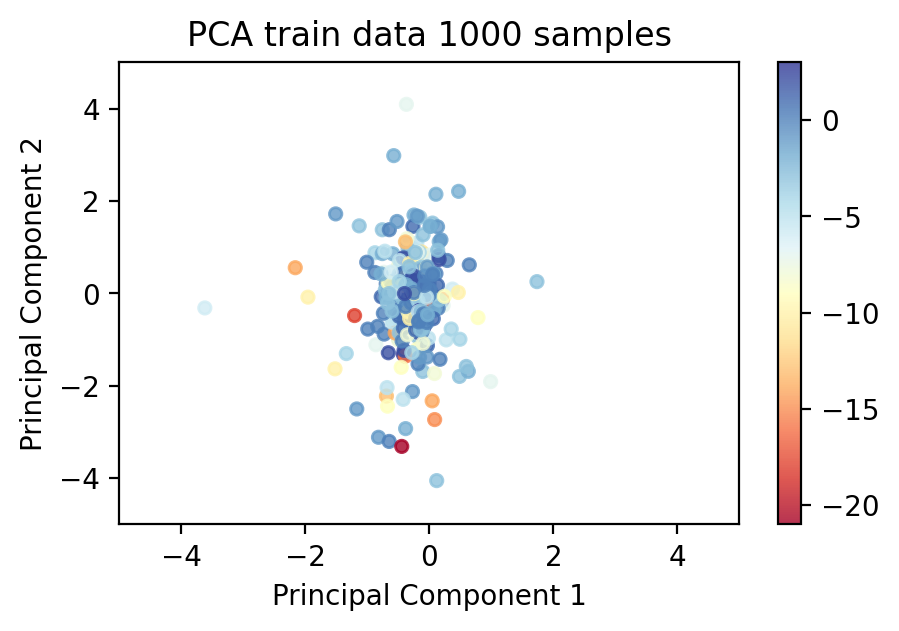

In [ ]:
pca = PCA(n_components=2)
#x_reshaped = x_test[0:500].reshape(-1, 784)              # new shape is (500, 28*28) = (500, 784)
#out2 = torch.tensor(data_emb)
# 10 out of 6230 output enteries all in out
#print(out2[0].shape) #torch.Size([10, 708])

#y_color_map = y_v[0]#.to(trainer.device)
y_color_map = torch.stack(y_v[0:300], dim=0)
y_color_map = y_color_map.view(-1,1)
y_color_map = y_color_map.detach().numpy()
#print('color',y_color_map.shape)
#print(y_color_map)
out2 = torch.stack(data_emb[0:300], dim=0)
out2 = out2.view(-1,192)
out2 = out2.detach().numpy()
#out2 = scaler.inverse_transform(out2[0].cpu().data.numpy())

x_scaled = StandardScaler().fit_transform(out2)    # center and scale data (mean=0, std=1)
x_transformed = pca.fit(x_scaled).transform(x_scaled)

plt.figure()
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(x_transformed[:, 0], x_transformed[:, 1],
            s=20, alpha=.8 , cmap=cm, c= y_color_map) # cmap='Set1', c=y_test[0:500]

plt.title("PCA train data 1000 samples")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.figsize"]=(5,3)

plt.colorbar(sc)
plt.show()